# Тестовое задание InfoTecs MLE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier

/tmp/ipykernel_78993/1913050988.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train_df = pd.read_csv('train.tsv', sep='\t')
val_df = pd.read_csv('val.tsv', sep='\t')

In [3]:
train_df.sample(3)

,is_virus,filename,libs
11879,0,ClipRenew.exe,"msvcrt.dll,ntdll.dll,api-ms-win-core-heap-l1-1..."
12180,1,VirusShare_4292b5f46157db45fc323e02edc54811,"kernel32.dll,msvbvm60.dll"
8614,0,rmiregistry.exe,"jli.dll,msvcr100.dll,kernel32.dll"


## Посчитаем некоторые статистики

Посчитаем некоторые статистики, чтобы разобраться с какими данными мы работаем.

In [4]:
train_df['libs'] = train_df['libs'].apply(lambda x: x.split(','))
val_df['libs'] = val_df['libs'].apply(lambda x: x.split(','))

In [5]:
train_df.sample(3)

,is_virus,filename,libs
8826,0,DXSETUP.exe,"[advapi32.dll, kernel32.dll, gdi32.dll, user32..."
8276,1,VirusShare_07f2842cf1b2975ea99869221b018bd5,"[kernel32.dll, comctl32.dll]"
8371,1,VirusShare_fa4ebbc053b95ab62f11475698199e6d,"[kernel32.dll, user32.dll, gdi32.dll, comdlg32..."


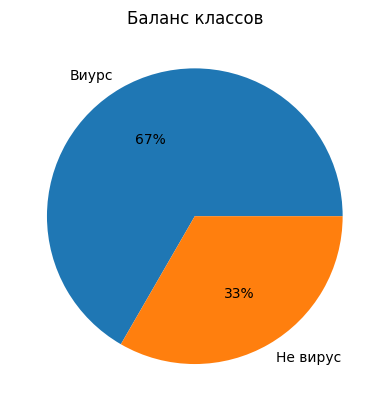

In [6]:
data = (train_df['is_virus'] == 1).sum(), (train_df['is_virus'] == 0).sum()
labels = ['Виурс', 'Не вирус']
plt.pie(data, labels=labels, autopct="%0.0f%%")
plt.title('Баланс классов')
plt.show()

Видим явный дисбаланас классов, можно использовать методы, которые хорошо работают с дисбалансом (Баессовский классификатор, бустинги и прочее), так же можно провести oversampling.

In [7]:
train_df['cnt_libs'] = train_df['libs'].apply(len)
corr_cnt_libs = train_df['cnt_libs'].corr(train_df['is_virus'])
print(f'Корреляция между количеством подключенных библиотек и флагом вируса: {round(corr_cnt_libs, 3)}')

Корреляция между количеством подключенных библиотек и флагом вируса: -0.242


In [8]:
val_df['cnt_libs'] = val_df['libs'].apply(len)

In [9]:
mean_include_libs = train_df['cnt_libs'].mean()
print(f'Среднее количество подключенных библиотек: {round(mean_include_libs, 2)}')

Среднее количество подключенных библиотек: 6.95


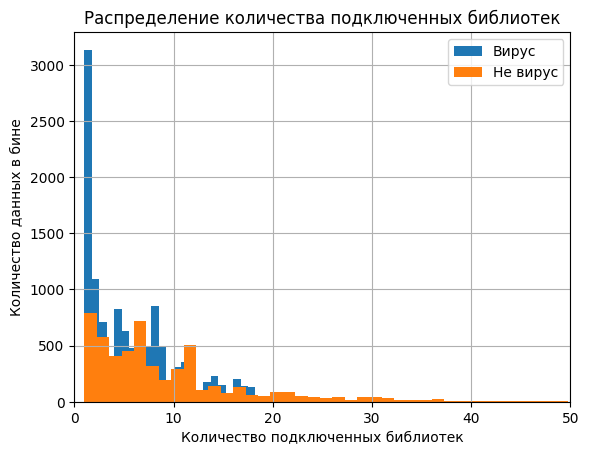

In [10]:
train_df.query('is_virus == 1')['cnt_libs'].hist(bins=100, label='Вирус')
train_df.query('is_virus == 0')['cnt_libs'].hist(bins=100, label='Не вирус')
plt.legend()
plt.xlabel('Количество подключенных библиотек')
plt.ylabel('Количество данных в бине')
plt.title('Распределение количества подключенных библиотек')
plt.xlim(0, 50)
plt.show()

Оставим признак.

In [11]:
uniq_libs = set()

for file_libs in train_df['libs']:
    for lib in file_libs:
        uniq_libs.add(lib)
print(f'Количество уникальных библиотек: {len(uniq_libs)}')

Количество уникальных библиотек: 1924


Получили огромное значение количества библиотек (наших признаков) попробуем убрать часть из них на основе их частоты их встречаемости и вероятности встретить их во вредоносном файле.

In [12]:
lib_occurrences = {}

for index, row in train_df.iterrows():
    for lib in row['libs']:
        if lib not in lib_occurrences:
            lib_occurrences[lib] = {'with_virus': 0, 'without_virus': 0}
        if row['is_virus'] == 1:
            lib_occurrences[lib]['with_virus'] += 1
        else:
            lib_occurrences[lib]['without_virus'] += 1

lib_df = pd.DataFrame.from_dict(lib_occurrences, orient='index')

lib_df['virus_percentage'] = lib_df['with_virus'] / (lib_df['with_virus'] + lib_df['without_virus'])
lib_df

,with_virus,without_virus,virus_percentage
kernel32.dll,11850,4846,0.709751
advapi32.dll,6630,2647,0.714671
comctl32.dll,2627,989,0.726493
comdlg32.dll,1230,391,0.758791
gdi32.dll,3709,1031,0.782489
...,...,...,...
cygomalloc-0-9-6.dll,0,1,0.000000
cygsingular_resources-4-1-1.dll,0,1,0.000000
hxcalendar.app.dll,0,1,0.000000
office.ui.xaml.core.dll,0,1,0.000000


Будем пробовать обучать модель с разным количеством признаков встречаемости наших признаков и с разными условиями выбора этих признаков. Пример ниже.

In [13]:
libs_query = '(virus_percentage >= 0.8 | virus_percentage <= 0.2) & (with_virus + without_virus >= 100)'
libs_set = set(lib_df.query(libs_query).index)
cnt_files_with_libs = train_df['libs'].apply(lambda x: any(lib in libs_set for lib in x)).sum()
print(f'Всего файлов: {train_df.shape[0]}')
print(f'Количество файлов, для которых есть хотя бы одна библиотека: {cnt_files_with_libs}')
print(f'Количество библиотек: {len(libs_set)}')

Всего файлов: 16290
Количество файлов, для которых есть хотя бы одна библиотека: 6924
Количество библиотек: 71


## Обучение первой модели (Логистическая регрессия)

Выберем линейную регрессию как первую модель, так как она быстро обучается и её веса можно интерпритировать как важность признаков, что позволит выполнить дополнительное задание.

Сначала напишем свой `column trasformer`, чтобы отбирать важные библиотеки.

Так как стандартный `MultiLabelBinarizer` не умеет работать с `ColumnTransformer` возьмем его из ответа на stackoverflow :) 

In [14]:
class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. Note
    that input X has to be a `pandas.DataFrame`.
    https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer
    """
    def __init__(self):
        self.mlbs = list()
        self.n_columns = 0
        self.categories_ = self.classes_ = list()

    def fit(self, X:pd.DataFrame, y=None):
        for i in range(X.shape[1]): # X can be of multiple columns
            mlb = MultiLabelBinarizer()
            mlb.fit(X.iloc[:,i])
            self.mlbs.append(mlb)
            self.classes_.append(mlb.classes_)
            self.n_columns += 1
        return self

    def transform(self, X:pd.DataFrame):
        if self.n_columns == 0:
            raise ValueError('Please fit the transformer first.')
        if self.n_columns != X.shape[1]:
            raise ValueError(f'The fit transformer deals with {self.n_columns} columns '
                             f'while the input has {X.shape[1]}.')
        result = list()
        for i in range(self.n_columns):
            result.append(self.mlbs[i].transform(X.iloc[:,i]))
        result = np.concatenate(result, axis=1)
        return result


class ImportantLibsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, upper_bound=0.75, lower_bound=0.25, cnt=100):
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.cnt = cnt
        self.important_libs_set = None
        self.all_libs_set = None

    def fit(self, X, y):
        df = pd.DataFrame(X, columns=['libs'])
        df['is_virus'] = y
        
        lib_occurrences = {}
        for index, row in df.iterrows():
            for lib in row['libs']:
                if lib not in lib_occurrences:
                    lib_occurrences[lib] = {'with_virus': 0, 'without_virus': 0}
                if row['is_virus'] == 1:
                    lib_occurrences[lib]['with_virus'] += 1
                else:
                    lib_occurrences[lib]['without_virus'] += 1
        
        lib_df = pd.DataFrame.from_dict(lib_occurrences, orient='index')
        lib_df['virus_percentage'] = lib_df['with_virus'] / (lib_df['with_virus'] + lib_df['without_virus'])
        libs_query = f'(virus_percentage >= {self.upper_bound} | virus_percentage <= {self.lower_bound}) & (with_virus + without_virus >= {self.cnt})'
        self.important_libs_set = set(lib_df.query(libs_query).index)
        self.all_libs_set = set(lib_df.index)
        return self

    def get_important_libs(self, libs_list):
        return [lib for lib in libs_list if lib in self.important_libs_set]
        
    def transform(self, X):
        transformed_X = []
        for _, libs_list in X.iterrows():
            important_libs = self.get_important_libs(*libs_list)
            transformed_X.append([important_libs])
        return pd.DataFrame(transformed_X, columns=['libs'])

Так же добавим `StandardScaler`, чтобы получить адекватно-распределенный признак `cnt_libs`.

Добавим параметр `class_weight` для того, чтобы избавиться от дисбаланса классов.

In [25]:
libs_pipeline = Pipeline([
    ('custom_lib_transformer', ImportantLibsTransformer()),
    ('multi_category_encoder', MultiHotEncoder())
])


ct = ColumnTransformer(
    transformers=[
        ('libs_pipeline', libs_pipeline, ['libs']),
        ('scaler', StandardScaler(), ['cnt_libs']),
    ],
    remainder='drop'
)

lr = LogisticRegression(solver='liblinear', 
                        max_iter=1_000)

pipeline = Pipeline([
    ('preprocessing', ct),
    ('classifier', lr)
])

Будет подбирать гиперпараметры c помощью кросс-валидации на 20 фолдах для нашего трансформера и для логистический регрессии. 

Параметром `class_weight` отрегулируем ложно-отрицательные предсказания (нам важно как можно меньше совершать ошибок первого рода, то есть не пропускать вредоносные файлы). 

In [26]:
best_params = {
    'preprocessing__libs_pipeline__custom_lib_transformer__upper_bound': [0.5, 0.55, 0.6],
    'preprocessing__libs_pipeline__custom_lib_transformer__lower_bound': [0.5, 0.45, 0.4],
    'preprocessing__libs_pipeline__custom_lib_transformer__cnt': [1, 5, 15],
    'classifier__C': [9, 10, 11],
    'classifier__class_weight': [{0: 2, 1: 1}, {0: 1, 1: 2}, {0: 1.25, 1: 2}],
    'classifier__penalty': ['l1']
}

grid_search = GridSearchCV(pipeline, 
                           best_params, 
                           cv=15, 
                           verbose=1,
                           scoring='accuracy',
                           refit=True,
                           n_jobs=3)

train_df = train_df.sample(frac=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(train_df[['libs', 'cnt_libs']], 
                                                    train_df['is_virus'], 
                                                    test_size=0.175, 
                                                    random_state=42)

grid_search.fit(X_train, y_train)

print("Лучшие параметры: ", grid_search.best_params_)

Fitting 15 folds for each of 243 candidates, totalling 3645 fits
Лучшие параметры:  {'classifier__C': 11, 'classifier__class_weight': {0: 1.25, 1: 2}, 'classifier__penalty': 'l1', 'preprocessing__libs_pipeline__custom_lib_transformer__cnt': 1, 'preprocessing__libs_pipeline__custom_lib_transformer__lower_bound': 0.5, 'preprocessing__libs_pipeline__custom_lib_transformer__upper_bound': 0.5}


In [17]:
def print_metrics(y_true, y_pred, decimals=4):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'True positive: {tp}',
          f'False positive: {fp}',
          f'False negative: {fn}',
          f'True negative: {tn}',
          f'Accuracy: {np.round(accuracy, decimals)}',
          f'Precision: {np.round(precision, decimals)}',
          f'Recall: {np.round(recall, decimals)}',
          f'F1: {np.round(f1, decimals)}',
          sep='\n')

Качество на отложенной тестовой выборке.

In [27]:
grid_search.best_estimator_.fit(X_train, 
                                y_train)

print_metrics(y_test, 
              grid_search.best_estimator_.predict(X_test))

True positive: 1904
False positive: 333
False negative: 30
True negative: 584
Accuracy: 0.8727
Precision: 0.8511
Recall: 0.9845
F1: 0.913


Качество на валидационной выборке.

In [28]:
grid_search.best_estimator_.fit(train_df[['cnt_libs', 'libs']], 
                                train_df['is_virus'])

print_metrics(val_df['is_virus'], 
              grid_search.best_estimator_.predict(val_df[['cnt_libs', 'libs']]))

True positive: 783
False positive: 140
False negative: 17
True negative: 260
Accuracy: 0.8692
Precision: 0.8483
Recall: 0.9788
F1: 0.9089


### Логистическая регрессия без feature engineering`а

In [20]:
ct = ColumnTransformer(
    transformers=[
        ('multi_category_encoder', MultiHotEncoder(), ['libs']),
        ('scaler', StandardScaler(), ['cnt_libs']),
    ],
    remainder='drop'
)

lr = LogisticRegression(solver='liblinear', 
                        max_iter=1_000)

pipeline = Pipeline([
    ('preprocessing', ct),
    ('classifier', lr)
])

best_params = {
    'classifier__C': [0.01, 1, 5, 10, 25],
    'classifier__class_weight': [{0: 1.5, 1: 1}, {0: 2, 1: 1}, {0: 1, 1: 2}, 'balanced'],
    'classifier__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(pipeline, 
                           best_params, 
                           cv=15, 
                           verbose=1,
                           scoring='accuracy',
                           refit=True,
                           n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(train_df[['libs', 'cnt_libs']], 
                                                    train_df['is_virus'], 
                                                    test_size=0.175, 
                                                    random_state=42)

grid_search.fit(X_train, y_train)

print("Лучшие параметры: ", grid_search.best_params_)

Fitting 15 folds for each of 40 candidates, totalling 600 fits


/home/gr/Projects/InfoTecs (old)/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['arkfs.dll', 'asynctask.dll', 'boost_date_time-vc100-mt-32-1_49.dll', 'boost_filesystem-vc100-mt-32-1_49.dll', 'boost_log-vc100-mt-32-1_49.dll', 'boost_program_options-vc100-mt-32-1_49.dll', 'boost_system-vc100-mt-32-1_49.dll', 'bugsplat.dll', 'cmfrgnet.dll', 'coremessaging.dll', 'cygexpat-1.dll', 'd3dx9_35.dll', 'devicecredential.dll', 'dfpcommon.dll', 'dhplay.dll', 'drvstore.dll', 'eax.dll', 'ext-ms-win-shell32-shellfolders-l1-1-0.dll', 'iphlpapi', 'jgsd400.dll', 'libgcc_s_dw2-1.dll', 'mdmdiagnostics.dll', 'miktex209-bibtex.dll', 'mmcbase.dll', 'netprojw.dll', 'oledlg', 'tinyxml.dll', 'vorbisfile.dll', 'wet.dll', 'x3daudio1_2.dll', 'zlib.dll'] will be ignored
  warnings.warn(
/home/gr/Projects/InfoTecs (old)/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['3cxuicontrols.dll', '3cxvoipphone.dll', 

Лучшие параметры:  {'classifier__C': 5, 'classifier__class_weight': {0: 1.5, 1: 1}, 'classifier__penalty': 'l1'}


Качество на отложенной тестовой выборке.

In [21]:
grid_search.best_estimator_.fit(X_train, 
                                y_train)

print_metrics(y_test, 
              grid_search.best_estimator_.predict(X_test))

True positive: 1807
False positive: 277
False negative: 88
True negative: 679
Accuracy: 0.872
Precision: 0.8671
Recall: 0.9536
F1: 0.9083


/home/gr/Projects/InfoTecs (old)/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['ab.dll', 'abview.dll', 'adsldpc.dll', 'api-ms-win-composition-redirection-l1-1-0.dll', 'api-ms-win-composition-windowmanager-l1-1-0.dll', 'api-ms-win-core-fibers-l2-1-0.dll', 'api-ms-win-core-fibers-l2-1-1.dll', 'api-ms-win-core-firmware-l1-1-0.dll', 'api-ms-win-core-normalization-l1-1-0.dll', 'api-ms-win-core-threadpool-l1-1-0.dll', 'api-ms-win-core-versionansi-l1-1-0.dll', 'api-ms-win-core-versionansi-l1-1-1.dll', 'api-ms-win-downlevel-shell32-l1-1-0.dll', 'api-ms-win-dx-d3dkmt-l1-1-0.dll', 'api-ms-win-ntuser-ie-message-l1-1-0.dll', 'api-ms-win-ntuser-ie-window-l1-1-0.dll', 'api-ms-win-rtcore-ntuser-private-l1-1-2.dll', 'astio.dll', 'bas60.dll', 'basroot.dll', 'bcgcbpro955u.dll', 'bluetoothserverdll.dll', 'boost_filesystem-vc140-mt-x64-1_68.dll', 'boost_locale-vc140-mt-x32-1_68.dll', 'boost_program_options-vc140-mt-x64-1_68.dll', 'boost_regex-vc140-

Качество на валидационной выборке.

In [22]:
grid_search.best_estimator_.fit(train_df[['cnt_libs', 'libs']], 
                                train_df['is_virus'])

print_metrics(val_df['is_virus'], 
              grid_search.best_estimator_.predict(val_df[['cnt_libs', 'libs']]))

True positive: 769
False positive: 114
False negative: 31
True negative: 286
Accuracy: 0.8792
Precision: 0.8709
Recall: 0.9612
F1: 0.9138


/home/gr/Projects/InfoTecs (old)/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['api-ms-win-shcore-scaling-l1-1-0.dll', 'ataport.sys', 'bdertl60.bpl', 'boost_filesystem-mt.dll', 'boost_system-mt.dll', 'certca.dll', 'commontoolkitsuitelight_x64.dll', 'contmenu.dll', 'cygffi-6.dll', 'cyggc-1.dll', 'dbrtl60.bpl', 'dbx60.bpl', 'diagtrack.dll', 'disko_core.dll', 'dsuiext.dll', 'gpapi.dll', 'kcdvmon.dll', 'kcns32.dll', 'kkey.dll', 'libpcre-1.dll', 'libpng15.dll', 'mfc42d.dll', 'mfcn42d.dll', 'mfco42d.dll', 'mgmtapi.dll', 'mnmddmod.dll', 'mozcrt19.dll', 'mscat32', 'msswch.dll', 'msvcrtd.dll', 'netsetupapi.dll', 'ntlanman.dll', 'nvsmartmax64.dll', 'pldataviewerremotingaccessor.dll', 'plobsproxy.dll', 'plrpaccessor.dll', 'png2bitmap.dll', 'rpcns4.dll', 'safecommon.dll', 'safegf.dll', 'sppcext.dll', 'vccorlib140.dll', 'vcldb60.bpl', 'vclx60.bpl', 'vmsif.dll', 'wecapi.dll', 'wmpdui.dll', 'wow32.dll', 'xgraphic32.dll', 'xmlide.dll'] will be i

## Обучение второй модели (Random forest)

In [34]:
libs_pipeline = Pipeline([
    ('custom_lib_transformer', ImportantLibsTransformer()),
    ('multi_category_encoder', MultiHotEncoder())
])


ct = ColumnTransformer(
    transformers=[
        ('libs_pipeline', libs_pipeline, ['libs']),
        ('scaler', StandardScaler(), ['cnt_libs']),
    ],
    remainder='drop'
)


rf = RandomForestClassifier({0: 1.5, 1: 1})

pipeline = Pipeline([
    ('preprocessing', ct),
    ('classifier', rf)
])

best_params = {
    'preprocessing__libs_pipeline__custom_lib_transformer__upper_bound': [0.5, 0.6, 0.7],
    'preprocessing__libs_pipeline__custom_lib_transformer__lower_bound': [0.5, 0.4, 0.3],
    'preprocessing__libs_pipeline__custom_lib_transformer__cnt': [1, 10, 25],
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 5, 15],
    'classifier__min_samples_split': [2, 5, 10], 
    'classifier__min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(pipeline, 
                           best_params, 
                           cv=10, 
                           verbose=1,
                           scoring='accuracy',
                           refit=True,
                           n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(train_df[['libs', 'cnt_libs']], 
                                                    train_df['is_virus'], 
                                                    test_size=0.175, 
                                                    random_state=42)

grid_search.fit(X_train, y_train)

print("Лучшие параметры: ", grid_search.best_params_)

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits
Лучшие параметры:  {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'preprocessing__libs_pipeline__custom_lib_transformer__cnt': 25, 'preprocessing__libs_pipeline__custom_lib_transformer__lower_bound': 0.5, 'preprocessing__libs_pipeline__custom_lib_transformer__upper_bound': 0.6}


In [35]:
grid_search.best_estimator_.fit(X_train, 
                                y_train)

print_metrics(y_test, 
              grid_search.best_estimator_.predict(X_test))

True positive: 1918
False positive: 413
False negative: 16
True negative: 504
Accuracy: 0.8495
Precision: 0.8228
Recall: 0.9917
F1: 0.8994


In [36]:
grid_search.best_estimator_.fit(train_df[['cnt_libs', 'libs']], 
                                train_df['is_virus'])

print_metrics(val_df['is_virus'], 
              grid_search.best_estimator_.predict(val_df[['cnt_libs', 'libs']]))

True positive: 794
False positive: 172
False negative: 6
True negative: 228
Accuracy: 0.8517
Precision: 0.8219
Recall: 0.9925
F1: 0.8992


## Что еще хотел, но не хватило времени или не хватило мощностей

* Нагенерировать фичи с комбинациями библиотек при помощи кластеризации, к примеру: [a,b,c,d] $\to$ [a,b,c,d, [a, b]],[a, b,d]]. Потом отобрать самые коррелируеющие с таргетом фичи и оставить их. Для этого на самом деле и писался колумн-трансформер, но для подбора таких фичей нужно больше вычислительный мощностей, чем один мой старый thinkpad.
* Подбирать параметров модели с помощью баессовских методов (должно получаться быстрее в разы) 
* Попробовать нейронную сеть. Она учтет взаимодействие между библиотеками, которое я описал в пунктке ниже. Причину считать файл зловредным можно получить, обучив логистическую регрессию для аппроксимации нейронной сети, далее таким же образом смотреть на веса логистической регресии.